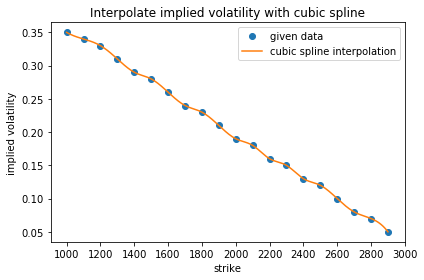

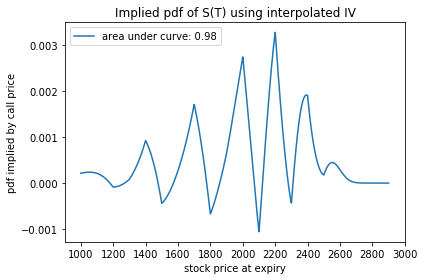

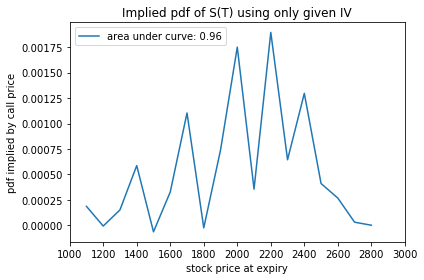

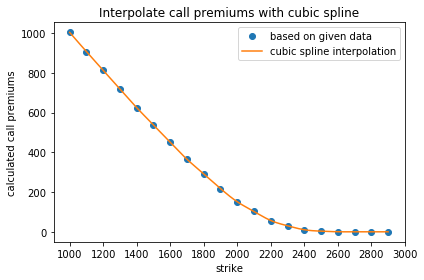

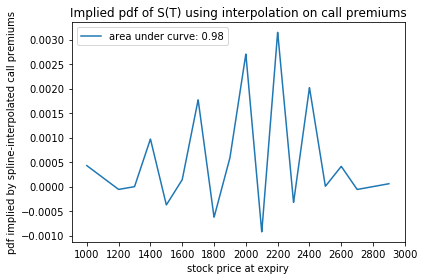

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
from scipy.interpolate import CubicSpline
%matplotlib inline

############################################################
# Simple data input
############################################################
strikes = np.array(range(1000,3000,100))
iv = [0.05, 0.07, 0.08, 0.1, 0.12, 0.13, 0.15, 0.16, 0.18, 0.19, 
      0.21, 0.23, 0.24, 0.26, 0.28, 0.29, 0.31, 0.33, 0.34, 0.35]
iv = np.array(list(reversed(iv)))

############################################################
# Interpolate implied volatility with spline
############################################################
iv_spline = CubicSpline(strikes, iv)
xs = range(1000,2910,10)
plt.figure()
plt.plot(strikes, iv, 'o', label='given data')
plt.plot(xs, iv_spline(xs), label='cubic spline interpolation')
plt.xlabel('strike')
plt.ylabel('implied volatility')
plt.xticks(range(1000,3200,200))
plt.title('Interpolate implied volatility with cubic spline')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('implied vol cubic spline')

############################################################
# Differentiate option price twice for risk neutral density
############################################################
def option_price(sig, k, is_call):
    ''' Calculate option price under given assumptions. 
    Assume zero risk free rate and dividend. F = 2000, T = 1 year 
    Args:
        sig (float): the implied volatility corresponding to strike k
        k (float): the strike price
        is_call (boolean): for simplicity, True for call and False for put
    Returns:
        float: the European option price with expiry of 1 year
    '''
    f, T = 2000, 1
    d1 = (math.log(f/k) + 0.5 * sig**2 * T) / (sig * T**0.5)
    d2 = d1 - sig * T**0.5
    if is_call:
        price = f * norm.cdf(d1) - k * norm.cdf(d2)
    else:
        price = k * norm.cdf(-d2) - f * norm.cdf(-d1)
    return price

# first method: use interpolated implied vol (IV) to calculate call price
# then differentiate call price twice to obtain implied density
k_range = np.arange(1000,2901,1)
call_implied_pdf = []
for k in k_range:
    # numerical estimate of the second derivative with dx = 1
    # use the cubic spline interpolated value of IV to price
    left = option_price(np.asscalar(iv_spline(k-1)), k-1, is_call=True)
    right = option_price(np.asscalar(iv_spline(k+1)), k+1, is_call=True)
    c = option_price(np.asscalar(iv_spline(k)), k, is_call=True)
    pdf = right - 2 * c + left
    call_implied_pdf.append(pdf)
# double check that the implied density should integrate to 1
curve_integral = np.trapz(call_implied_pdf, x=k_range)
label = 'area under curve: {:.2f}'.format(curve_integral)
plt.figure()
plt.plot(k_range, call_implied_pdf, label=label)
plt.xlabel('stock price at expiry')
plt.ylabel('pdf implied by call price')
plt.xticks(range(1000,3200,200))
plt.title('Implied pdf of S(T) using interpolated IV')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('call implied pdf with interpolated iv')

# second method: do not interpolate implied vol (IV)
# instead directly use given IV to differentiate call price at big step size
# the error in this numerical differentiation is high at O(h**2)
# but we include only for completeness
sparse_call_implied_pdf = []
for i in range(1, strikes.size-1):
    left = option_price(iv[i-1], strikes[i-1], is_call=True)
    right = option_price(iv[i+1], strikes[i+1], is_call=True)
    c = option_price(iv[i], strikes[i], is_call=True)
    pdf = (right - 2 * c + left) / (strikes[i+1] - strikes[i])**2
    sparse_call_implied_pdf.append(pdf)
curve_integral = np.trapz(sparse_call_implied_pdf, x=strikes[1:-1])
label = 'area under curve: {:.2f}'.format(curve_integral)
plt.figure()
plt.plot(strikes[1:-1], sparse_call_implied_pdf, label=label)
plt.xlabel('stock price at expiry')
plt.ylabel('pdf implied by call price')
plt.xticks(range(1000,3200,200))
plt.title('Implied pdf of S(T) using only given IV')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('call implied pdf with only given iv')

# third method: price calls at given IV then use cubic spline on call prices
call_prices = [option_price(iv, k, is_call=True) for iv, k in zip(iv, strikes)]
c_spline = CubicSpline(strikes, call_prices)
k_range = np.arange(999,2902,1)
interp_call_prices = c_spline(k_range)
# plot the cubic spline interpolation of call premiums
plt.figure()
plt.plot(strikes, call_prices, 'o', label='based on given data')
plt.plot(k_range[1:-1], interp_call_prices[1:-1], label='cubic spline interpolation')
plt.xlabel('strike')
plt.ylabel('calculated call premiums')
plt.xticks(range(1000,3200,200))
plt.title('Interpolate call premiums with cubic spline')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('call premium cubic spline')
# now numerically differentiate with FDM step dx=1
interp_call_implied_pdf = [interp_call_prices[i-1] - 2*interp_call_prices[i] + interp_call_prices[i+1] 
                           for i in range(1, len(k_range)-1)]
curve_integral = np.trapz(interp_call_implied_pdf, x=k_range[1:-1])
label = 'area under curve: {:.2f}'.format(curve_integral)
plt.figure()
plt.plot(k_range[1:-1], interp_call_implied_pdf, label=label)
plt.xlabel('stock price at expiry')
plt.ylabel('pdf implied by spline-interpolated call premiums')
plt.xticks(range(1000,3200,200))
plt.title('Implied pdf of S(T) using interpolation on call premiums')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('call implied pdf with interpolated call premiums')
